In [29]:
import sys

from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import time
from random import randint
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,log_loss
from scipy.stats import ks_2samp

import pdb

import scipy as sp
from tqdm import tqdm, tqdm_notebook

import os
import glob

import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import torch.utils as U

import torchvision
from torchvision import transforms as T
from torchvision import models as M

import matplotlib.pyplot as plt

PATH = Path('C:/StudioProjects/Hemorrhage')
PATH_WORK = Path('C:/StudioProjects/Hemorrhage/running')

import lightgbm as lgb
from collections import defaultdict, Counter
import random
import seaborn as sn
from eli5.permutation_importance import get_score_importances

pd.set_option("display.max_columns", 100)

all_ich = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']

In [96]:
train_md.head()

,BitsAllocated,BitsStored,HighBit,ImageOrientationPatient,ImagePositionPatient,Modality,PatientID,PhotometricInterpretation,PixelRepresentation,PixelSpacing,RescaleIntercept,RescaleSlope,SOPInstanceUID,SamplesPerPixel,SeriesInstanceUID,StudyID,StudyInstanceUID,WindowCenter,WindowWidth,ImageOrientationPatient_0,ImageOrientationPatient_1,ImageOrientationPatient_2,ImageOrientationPatient_3,ImageOrientationPatient_4,ImageOrientationPatient_5,ImagePositionPatient_0,ImagePositionPatient_1,ImagePositionPatient_2,PixelSpacing_0,PixelSpacing_1,WindowCenter_0,WindowCenter_1,WindowCenter_1_NAN,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,weight,grp_weight
0,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000', '-123.101', '104.307']",CT,ID_b81a287f,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_231d901c1,1,ID_15dcd6057a,NaN,ID_dd37ba3adb,40,100,1.0,0.0,0.0,0.0,0.984808,-0.173648,-125.0,-123.101000,104.307000,0.488281,0.488281,40.0,38.015255,0,1,0,0,0,1,0,0.015365,40.0
1,16,1,11,"['1', '0', '0', '0', '0.933580426', '-0.358367...","['-125', '53.6282216', '223.572015']",CT,ID_400facde,MONOCHROME2,1,"['0.48828125', '0.48828125']",0,1.0,ID_994bc0470,1,ID_4ba12c2161,NaN,ID_c5277f0c63,"['00047', '00047']","['00080', '00080']",1.0,0.0,0.0,0.0,0.933580,-0.358368,-125.0,53.628222,223.572015,0.488281,0.488281,47.0,47.000000,1,0,0,0,0,0,0,0.001997,47.0
2,16,0,15,"['1.000000', '0.000000', '0.000000', '0.000000...","['-125.000000', '-123.646240', '124.321068']",CT,ID_42910d3d,MONOCHROME2,0,"['0.488281', '0.488281']",0,1.0,ID_127689cce,1,ID_c4b4931314,NaN,ID_db93ade25b,30,80,1.0,0.0,0.0,0.0,0.972370,-0.233445,-125.0,-123.646240,124.321068,0.488281,0.488281,30.0,38.015255,0,0,0,0,0,0,0,0.269672,30.0
3,16,1,11,"['1', '0', '0', '0', '1', '0']","['-114', '-6', '171.999939']",CT,ID_329aafa7,MONOCHROME2,1,"['0.4453125', '0.4453125']",0,1.0,ID_25457734a,1,ID_116558f409,NaN,ID_8dd6d32f3b,"['00036', '00036']","['00080', '00080']",1.0,0.0,0.0,0.0,1.000000,0.000000,-114.0,-6.000000,171.999939,0.445312,0.445312,36.0,36.000000,1,0,0,0,0,0,0,0.003259,36.0
4,16,1,11,"['1', '0', '0', '0', '1', '0']","['-115', '-1', '230.5']",CT,ID_6b544c3c,MONOCHROME2,1,"['0.44921875', '0.44921875']",0,1.0,ID_81c9aa125,1,ID_f56d7bd0f9,NaN,ID_2685c5d5c0,"['00036', '00036']","['00080', '00080']",1.0,0.0,0.0,0.0,1.000000,0.000000,-115.0,-1.000000,230.500000,0.449219,0.449219,36.0,36.000000,1,0,0,0,0,0,0,0.005538,36.0


In [95]:
pd.read_csv(PATH/'stage_1_train.csv').shape[0]/6

674262.0

In [2]:
train_df = pd.read_csv(PATH_WORK/'train_df.csv')
train_md = pd.read_csv(PATH_WORK/'train_md.csv')
test_md = pd.read_csv(PATH_WORK/'test_md.csv')

# Prepare meta data

In [77]:
train_csv = pd.read_csv(PATH/'stage_1_train.csv')

train_csv = train_csv.loc[~train_csv.ID.duplicated()].sort_values('ID').reset_index(drop=True)
all_sop_ids = train_csv.ID.str.split('_').apply(lambda x: x[0]+'_'+x[1]).unique()
train_df = pd.DataFrame(train_csv.Label.values.reshape((-1,6)), columns = all_ich)
train_df['sop_id'] = all_sop_ids

train_df.to_csv(PATH_WORK/'train_df.csv', index=False)

In [4]:
train_md = pd.read_csv(PATH/'train_metadata.csv')
test_md = pd.read_csv(PATH/'test_metadata.csv')
test_md = test_md.sort_values('SOPInstanceUID')
data_md = pd.concat([train_md, test_md], axis=0, sort=False).reset_index(drop=True)

In [5]:
del data_md['Unnamed: 0']

for i in range(6):
    data_md['ImageOrientationPatient_{}'.format(i)] \
        = data_md['ImageOrientationPatient'].str.split('\'').apply(lambda x: x[1+2*i])

for i in range(3):
    data_md['ImagePositionPatient_{}'.format(i)] \
        = data_md['ImagePositionPatient'].str.split('\'').apply(lambda x: x[1+2*i])

for i in range(2):
    data_md['PixelSpacing_{}'.format(i)] \
        = data_md['PixelSpacing'].str.split('\'').apply(lambda x: x[1+2*i])

data_md['WindowCenter_0'] \
    = data_md['WindowCenter'].str.split('\'').apply(lambda x: float(x[1]) if len(x) > 1 else float(x[0]))

data_md['WindowCenter_1'] \
    = data_md['WindowCenter'].str.split('\'').apply(lambda x: float(x[3]) if len(x) > 1 else np.nan)

data_md['WindowCenter_1_NAN'] = data_md.WindowCenter_1.isnull()

data_md.loc[data_md.WindowCenter_1.isnull(), 'WindowCenter_1'] \
    = data_md.loc[~data_md.WindowCenter_1.isnull(), 'WindowCenter_1'].mean()

In [6]:
cols_cat = ['BitsStored','PixelRepresentation','RescaleIntercept','WindowCenter_1_NAN']
cols_float = ['ImageOrientationPatient_0', 'ImageOrientationPatient_1',
       'ImageOrientationPatient_2', 'ImageOrientationPatient_3',
       'ImageOrientationPatient_4', 'ImageOrientationPatient_5',
       'ImagePositionPatient_0', 'ImagePositionPatient_1','ImagePositionPatient_2',
        'PixelSpacing_0', 'PixelSpacing_1', 'WindowCenter_0', 'WindowCenter_1']

for col in cols_float:
    data_md[col] = data_md[col].astype(float)

for col in cols_cat:
    data_md[col] = pd.factorize(data_md[col])[0]
    data_md[col] = data_md[col].astype('category')

In [7]:
data_md = data_md.join(train_df.set_index('sop_id'), on = 'SOPInstanceUID')

In [8]:
for col in cols_cat:
    print(pd.crosstab(data_md[col], data_md['any'].isnull()))

any          False  True 
BitsStored               
0           341679  75369
1           332579   3176
any                   False  True 
PixelRepresentation               
0                    343931  75429
1                    330327   3116
any                False  True 
RescaleIntercept               
0                 662279  78457
1                   5276     60
2                   6653     28
3                     50      0
any                  False  True 
WindowCenter_1_NAN               
0                   341679  75369
1                   332579   3176


In [9]:
train_md = data_md.loc[~data_md['any'].isnull()].copy()
for col in all_ich:
    train_md[col] = train_md[col].astype(int)
train_md.to_csv(PATH_WORK/'train_md.csv', index=False)

test_md = data_md.loc[data_md['any'].isnull()].copy()
test_md.to_csv(PATH_WORK/'test_md.csv', index=False)

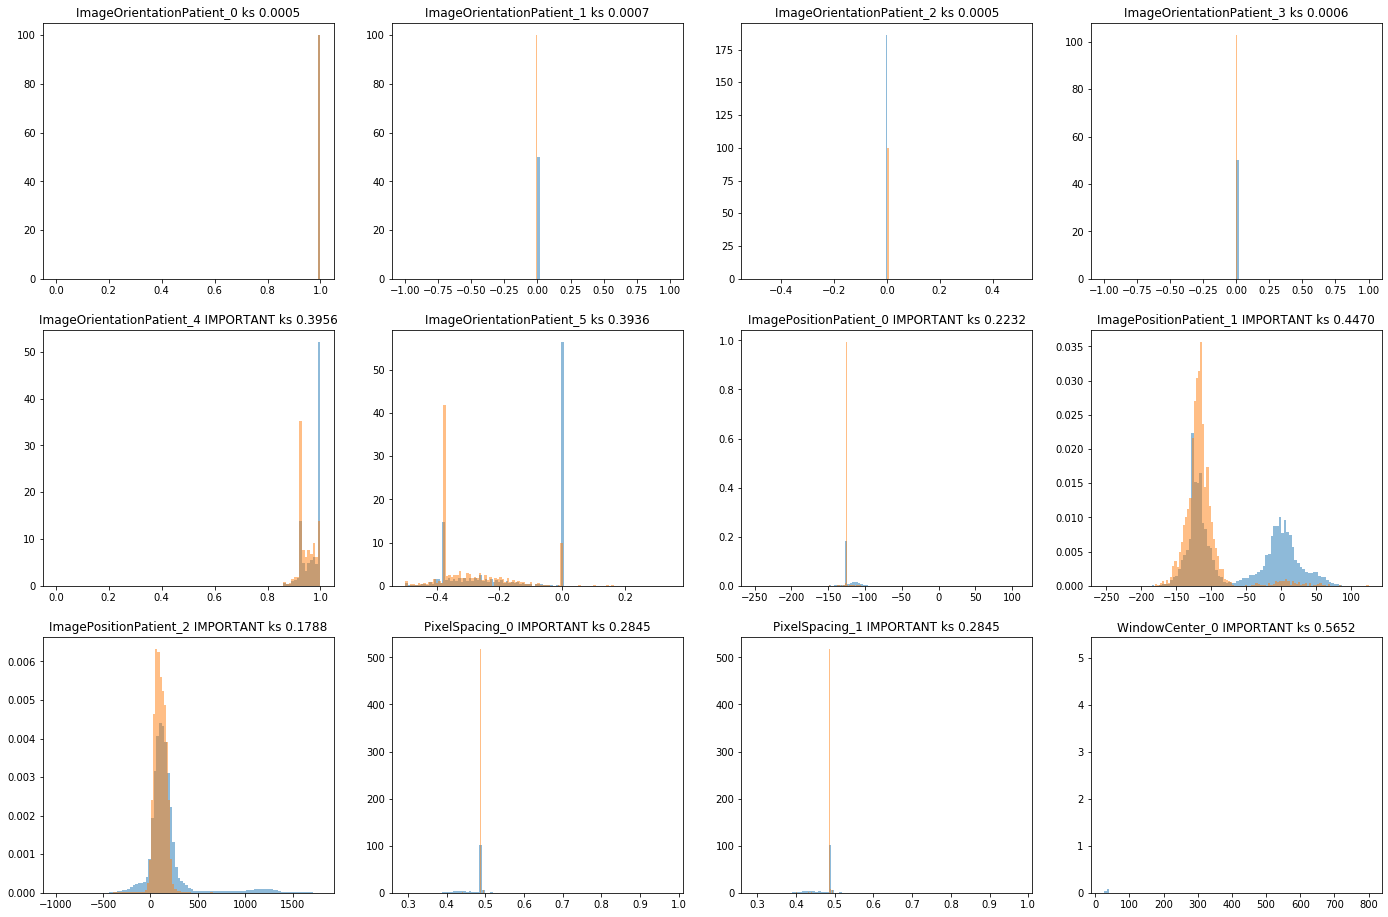

In [434]:
fig, axes = plt.subplots(3, 4, figsize=(24, 16))

for i, ax in enumerate(axes.flatten()):
    if i == len(cols_float): continue
    col = cols_float[i]
    a = ax.hist(train_md[col], bins=100, density=True, alpha=0.5)
    a = ax.hist(test_md[col], bins=100, density=True, alpha=0.5)
    ks = ks_2samp(train_md[col].values, test_md[col].values)
    ax.set_title(col + (' IMPORTANT' if col in significant_cols else '') + ' ks {:.4f}'.format(ks.statistic))

# Matching weights

In [97]:
data_md['weight'] = 1

for k in range(3):
    #for col in ['PixelSpacing_0']:
    for col in significant_cols:

        if len(data_md[col].unique()) <= 100:
            data_md['grp_weight'] = data_md[col]
        else:
            data_md['grp_weight'] = pd.qcut(data_md[col],100,duplicates='drop')

        ww = data_md[['grp_weight','any','weight']].groupby('grp_weight')\
            .apply(lambda x: x['any'].isnull().sum()/((x.weight[~x['any'].isnull()]).sum() + 1e-6))
        ww = pd.DataFrame(ww, columns = ['weight_fac'])
        print(ww.head())
        
        data_md = data_md.join(ww, on = 'grp_weight')
        data_md.loc[~data_md['any'].isnull(),'weight'] *= data_md.loc[~data_md['any'].isnull(),'weight_fac']

        del data_md['weight_fac']
        del data_md['grp_weight']

            weight_fac
grp_weight            
0             0.219314
1             0.009433
                      weight_fac
grp_weight                      
(-1e-07, 0.882948]      1.052483
(0.882948, 0.898794]    1.078284
(0.898794, 0.906308]    0.877193
(0.906308, 0.913545]    1.193759
(0.913545, 0.91706]     0.765272
                    weight_fac
grp_weight                    
(-250.001, -155.0]    0.978966
(-155.0, -146.0]      1.154209
(-146.0, -139.5]      1.297924
(-139.5, -135.9]      1.856063
(-135.9, -133.0]      1.321971
                        weight_fac
grp_weight                        
(-253.40001, -153.887]    1.351667
(-153.887, -147.3]        1.419645
(-147.3, -143.661]        1.037324
(-143.661, -141.03061]    0.921146
(-141.03061, -138.637]    1.184098
                      weight_fac
grp_weight                      
(-998.401, -227.348]    1.229897
(-227.348, -162.8]      1.347740
(-162.8, -114.8]        1.156776
(-114.8, -71.0]         0.949772
(-71.0, -36.069] 

In [98]:
train_md = data_md.loc[~data_md['any'].isnull()].copy()
for col in all_ich:
    train_md[col] = train_md[col].astype(int)

test_md = data_md.loc[data_md['any'].isnull()].copy()

In [99]:
train_md.to_csv(PATH_WORK/'train_md.csv', index=False)
test_md.to_csv(PATH_WORK/'test_md.csv', index=False)

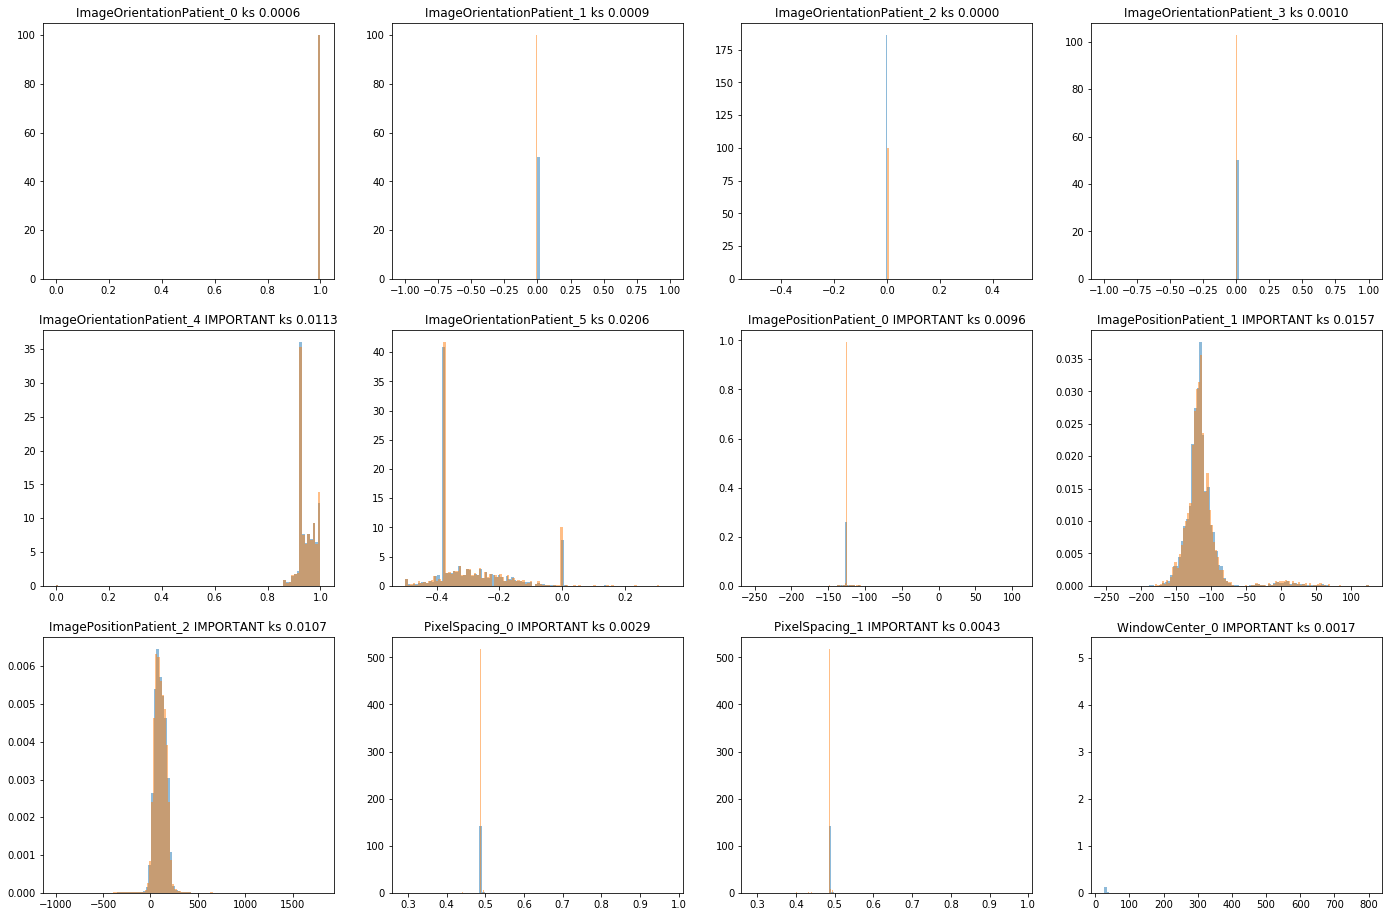

In [52]:
fig, axes = plt.subplots(3, 4, figsize=(24, 16))

for i, ax in enumerate(axes.flatten()):
    if i == len(cols_float): continue
    col = cols_float[i]
    a = ax.hist(train_md[col], bins=100, density=True, alpha=0.5, weights = train_md.weight)
    a = ax.hist(test_md[col], bins=100, density=True, alpha=0.5, weights = test_md.weight)
    sampled = np.random.choice(train_md[col].values,10000,p=train_md.weight/train_md.weight.sum())
    ks = ks_2samp(sampled, test_md[col].values)
    ax.set_title(col + (' IMPORTANT' if col in significant_cols else '') + ' ks {:.4f}'.format(ks.statistic))

In [102]:
(train_md.weight > 0.1).mean()

0.33415102230896776

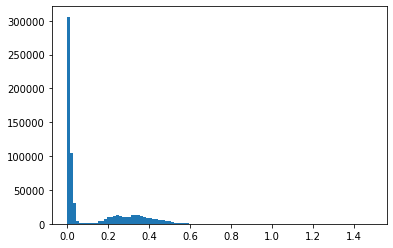

In [101]:
a = plt.hist(train_md.weight, bins=100)

# LightGBM

https://dicom.innolitics.com/ciods/ct-image/image-plane/00200037

Bits Allocated Attribute
Tag	(0028,0100)
Type	Required (1)
Keyword	BitsAllocated
Value Multiplicity	1
Value Representation	Unsigned Short (US)
Number of bits allocated for each pixel sample. Each sample shall have the same number of bits allocated. Bits Allocated (0028,0100) shall be either 1, or a multiple of 8. See PS3.5 for further explanation.

Bits Stored Attribute
Tag	(0028,0101)
Type	Required (1)
Keyword	BitsStored
Value Multiplicity	1
Value Representation	Unsigned Short (US)
Number of bits stored for each pixel sample. Each sample shall have the same number of bits stored. See PS3.5 for further explanation.

High Bit Attribute
Tag	(0028,0102)
Type	Required (1)
Keyword	HighBit
Value Multiplicity	1
Value Representation	Unsigned Short (US)
Most significant bit for pixel sample data. Each sample shall have the same high bit. High Bit (0028,0102) shall be one less than Bits Stored (0028,0101). See PS3.5 for further explanation.

--- STRONG (4) ---
Image Orientation (Patient) Attribute
Tag	(0020,0037)
Type	Required (1)
Keyword	ImageOrientationPatient
Value Multiplicity	6
Value Representation	Decimal String (DS)
The direction cosines of the first row and the first column with respect to the patient. See Section C.7.6.2.1.1 for further explanation.

--- STRONG (0,1,2) ---
Image Position (Patient) Attribute
Tag	(0020,0032)
Type	Required (1)
Keyword	ImagePositionPatient
Value Multiplicity	3
Value Representation	Decimal String (DS)
The x, y, and z coordinates of the upper left hand corner (center of the first voxel transmitted) of the image, in mm. See Section C.7.6.2.1.1 for further explanation.

--- STRONG ---
Pixel Representation Attribute
Tag	(0028,0103)
Type	Required (1)
Keyword	PixelRepresentation
Value Multiplicity	1
Value Representation	Unsigned Short (US)
Data representation of the pixel samples. Each sample shall have the same pixel representation.

--- STRONG (0,1) ---
Pixel Spacing Attribute
Tag	(0028,0030)
Type	Required (1)
Keyword	PixelSpacing
Value Multiplicity	2
Value Representation	Decimal String (DS)
Physical distance in the patient between the center of each pixel, specified by a numeric pair - adjacent row spacing (delimiter) adjacent column spacing in mm. See Section 10.7.1.3 for further explanation.

Rescale Intercept Attribute
Tag	(0028,1052)
Type	Required (1)
Keyword	RescaleIntercept
Value Multiplicity	1
Value Representation	Decimal String (DS)
The value b in relationship between stored values (SV) and the output units.
Output units = m*SV+b
If Image Type (0008,0008) Value 1 is ORIGINAL and Value 3 is not LOCALIZER, output units shall be Hounsfield Units (HU).

--- STRONG (0) ---
Window Center Attribute
Tag	(0028,1050)
Type	Conditionally Required (1C)
Keyword	WindowCenter
Value Multiplicity	1-n
Value Representation	Decimal String (DS)
Window Center for display.
See Section C.11.2.1.2 for further explanation.
Required if VOI LUT Sequence (0028,3010) is not present. May be present otherwise.

Window Width Attribute
Tag	(0028,1051)
Type	Conditionally Required (1C)
Keyword	WindowWidth
Value Multiplicity	1-n
Value Representation	Decimal String (DS)
Window Width for display. See Section C.11.2.1.2 for further explanation.
Required if Window Center (0028,1050) is present.

In [53]:
def stratified_group_k_fold(X, y, groups, k, seed=42):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [54]:
params_lgb = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 7,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.6,
    'bagging_freq': 1,
    'learning_rate': 0.05
}

In [55]:
FOLDS = 3

def train_one(data = None, run_perm = False, target = 'qt', weight = None, group_col = None):
    
    fi = pd.DataFrame()
    models = []
    
    my_seed = 1235
    random.seed(my_seed)
    np.random.seed(my_seed)
    
    for i, (dev_index, val_index) in enumerate(stratified_group_k_fold(
                data,data[target],groups=group_col,k=FOLDS,seed=my_seed)):
        data.loc[val_index,'fold'] = i
    
    data_filt = data.copy()
    del data_filt[target]
    
    predictions = np.zeros(len(data_filt))
    
    for i in range(FOLDS):
        
        Xt, Xv = data_filt.loc[data_filt['fold'] != i, :], data_filt.loc[data_filt['fold'] == i, :]
        yt, yv = data.loc[data_filt['fold'] != i, target], data.loc[data_filt['fold'] == i, target]
        Xt = Xt.drop('fold', axis=1)
        Xv = Xv.drop('fold', axis=1)
        
        wt = None
        wv = None
        if weight is not None:
            wt = weight[data_filt['fold'] != i]
            wv = weight[data_filt['fold'] == i]
        
        print('Fold', i, 'weight', np.sum(wt))
        
        d_train = lgb.Dataset(Xt, yt, weight = wt)
        d_valid = lgb.Dataset(Xv, yv, weight = wv)

        watchlist = [d_train, d_valid]
        model = lgb.train(params_lgb,
                          train_set=d_train,
                          num_boost_round=200,
                          valid_sets=watchlist,
                          verbose_eval=10,
                          early_stopping_rounds=20)

        predictions[data_filt['fold'] == i] = model.predict(Xv, num_iteration=model.best_iteration)

        if run_perm:
            def eli_score(X, y):
                y_pred = model.predict(X, num_iteration=model.best_iteration)
                return np.abs(np.clip(y_pred,0,14) - y).mean()

            base_score, score_decreases = get_score_importances(eli_score, np.array(Xv), yv.values, 
                                                                random_state=1000+10*i)
            fi = pd.concat([fi, pd.DataFrame(np.array(score_decreases), columns = Xt.columns)], axis=0)
        else:
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = Xt.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = i
            fi = pd.concat([fi, fold_importance], axis=0)

        models.append(model)
    
    print('Log-loss', log_loss(data[target],predictions))
    print('correlation', np.corrcoef(data[target],predictions)[0,1])
    
    return predictions, models, fi

In [56]:
#['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
target = 'any'
train_md_filt = train_md.loc[:,cols_cat + cols_float + [target]]
#train_md_filt = train_md.loc[:,significant_cols + [target]]

In [259]:
weights = None

In [383]:
weights = np.zeros(len(train_md))
weights[train_md[target] == 1] = 1/train_md[target].mean()
weights[train_md[target] == 0] = 1/(1-train_md[target].mean())

In [57]:
weights = train_md.weight

In [58]:
predictions, models, fi = train_one(data = train_md_filt, target = target, weight = weights,
                                    group_col = train_md['PatientID'].values, run_perm = False)

Fold 0 weight 52085.24332544031


C:\Users\nosou\Anaconda3\envs\fastai\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	training's binary_logloss: 0.24315	valid_1's binary_logloss: 0.253397
[20]	training's binary_logloss: 0.233951	valid_1's binary_logloss: 0.246845
[30]	training's binary_logloss: 0.227142	valid_1's binary_logloss: 0.244899
[40]	training's binary_logloss: 0.222373	valid_1's binary_logloss: 0.244304
[50]	training's binary_logloss: 0.218732	valid_1's binary_logloss: 0.244317
[60]	training's binary_logloss: 0.216361	valid_1's binary_logloss: 0.244488
[70]	training's binary_logloss: 0.213373	valid_1's binary_logloss: 0.24503
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.218255	valid_1's binary_logloss: 0.244214
Fold 1 weight 52651.63260312157
Training until validation scores don't improve for 20 rounds.
[10]	training's binary_logloss: 0.249686	valid_1's binary_logloss: 0.241597
[20]	training's binary_logloss: 0.2385	valid_1's binary_logloss: 0.235433
[30]	training's binary_logloss: 0.232087	valid_1's bi

In [ ]:
# Log-loss 0.3199663177316350
# Log-loss 0.3199656382395672 - seed 1235
# Log-loss 0.3199215860958348 - seed 1235 / only significant
# Log-loss 0.3193615167492591 - only significant
# Log-loss 0.3195333145247021
# Log-loss 0.3197181080279387
# Log-loss 0.319863484530601
# Log-loss 0.3200582941680835

In [59]:
predictions.max()

0.7978670348307371

In [60]:
predictions.min()

0.007832802543123706

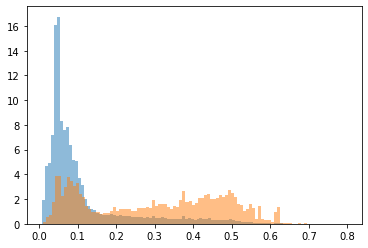

In [61]:
a = plt.hist(predictions[train_md['any'].values == 0], bins=100, density=True, alpha=0.5)
a = plt.hist(predictions[train_md['any'].values == 1], bins=100, density=True, alpha=0.5)

In [202]:
scores = fi.max(0)
significant_cols = scores[scores < 0].index.values
significant_cols

array(['PixelRepresentation', 'ImageOrientationPatient_4',
       'ImagePositionPatient_0', 'ImagePositionPatient_1',
       'ImagePositionPatient_2', 'PixelSpacing_0', 'PixelSpacing_1',
       'WindowCenter_0'], dtype=object)

In [11]:
significant_cols = ['PixelRepresentation', 'ImageOrientationPatient_4',
       'ImagePositionPatient_0', 'ImagePositionPatient_1',
       'ImagePositionPatient_2', 'PixelSpacing_0', 'PixelSpacing_1',
       'WindowCenter_0']

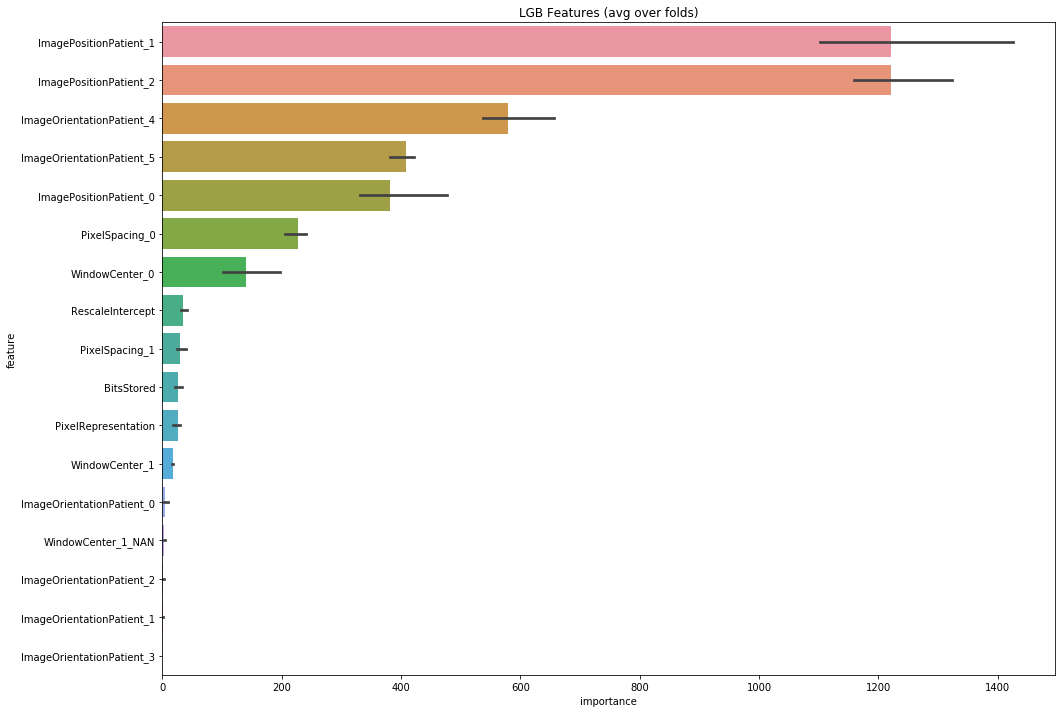

In [62]:
fi['score'] = fi[["feature", "importance"]].groupby('feature').transform('mean')

cols = fi[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index
best_features = fi.loc[fi.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sn.barplot(x="importance", y="feature", data=best_features.sort_values(by="score", ascending=False));
plt.title('LGB Features (avg over folds)');

# Prediction

In [86]:
test_md_filt = test_md.loc[:,cols_cat + cols_float]
preds = np.zeros((FOLDS,len(test_md)))
for i in range(FOLDS):
    preds[i,:] = models[i].predict(test_md_filt, num_iteration=models[i].best_iteration)

In [87]:
preds = preds.mean(0)

In [64]:
#preds = preds.mean(0)
preds = np.exp(np.log(preds).mean(0))

In [80]:
preds.mean()

0.07437373434186983

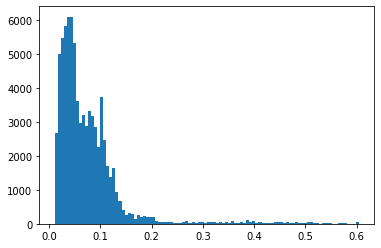

In [81]:
a = plt.hist(preds,bins=100)

In [67]:
predictions.mean()

0.13847677632686278

In [68]:
predictions.mean()

0.13847677632686278

In [69]:
(predictions*weights).mean()/weights.mean()

0.07589208670021227

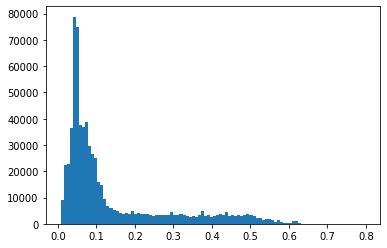

In [70]:
a = plt.hist(predictions,bins=100)

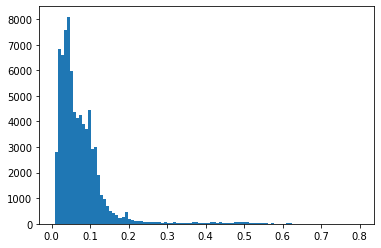

In [71]:
a = plt.hist(predictions,bins=100,weights=weights)

In [88]:
sub = pd.read_csv(PATH/'submission20.csv')

In [73]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.1255341744607709

In [74]:
assert np.all(test_md.SOPInstanceUID.apply(lambda x: x + '_any').values == sub.loc[range(0,len(sub),6)].ID.values)

In [82]:
np.corrcoef(sub.loc[range(0,len(sub),6), 'Label'], preds)[0,1]

0.30144820570391995

In [83]:
sub.loc[range(0,len(sub),6), 'Label'] = np.exp(0.95*np.log(sub.loc[range(0,len(sub),6), 'Label']) + 0.05*np.log(preds))

In [89]:
sub.loc[range(0,len(sub),6), 'Label'] = 0.95*sub.loc[range(0,len(sub),6), 'Label'] + 0.05*preds

In [363]:
sub.Label *= 0.98

In [90]:
sub.to_csv(PATH/'submission.csv', index=False)

# Confusion matrix

In [5]:
mat = np.array(train_df.loc[:,train_df.columns[:6]].values, dtype=float)
np.matmul(mat.transpose(),mat)

array([[97103.,  2761., 32564., 23766., 32122., 42496.],
       [ 2761.,  2761.,   556.,   216.,   484.,   645.],
       [32564.,   556., 32564.,  9616.,  8321.,  6541.],
       [23766.,   216.,  9616., 23766.,  6735.,  3404.],
       [32122.,   484.,  8321.,  6735., 32122.,  8505.],
       [42496.,   645.,  6541.,  3404.,  8505., 42496.]])

In [6]:
mat.mean(0)

array([0.144 , 0.0041, 0.0483, 0.0352, 0.0476, 0.063 ])

In [348]:
for i in range(6):
    print(sub.loc[range(i,len(sub),6), 'Label'].mean())

0.12304686302872321
0.003958621945498708
0.04364857134731329
0.0272813377865004
0.04397713774839064
0.0517257743941261


In [7]:
np.set_printoptions(precision=4)
mat /= np.sqrt(mat.sum(0))
np.matmul(mat.transpose(),mat)

array([[1.    , 0.1686, 0.5791, 0.4947, 0.5752, 0.6615],
       [0.1686, 1.    , 0.0586, 0.0267, 0.0514, 0.0595],
       [0.5791, 0.0586, 1.    , 0.3457, 0.2573, 0.1758],
       [0.4947, 0.0267, 0.3457, 1.    , 0.2438, 0.1071],
       [0.5752, 0.0514, 0.2573, 0.2438, 1.    , 0.2302],
       [0.6615, 0.0595, 0.1758, 0.1071, 0.2302, 1.    ]])